## Capstone Project - The Battle of Neighborhoods 
### Peer graded assignment


### Introduction:

Discussing the matter with my family, my uncle just commented that he has been thinking of opening a restaurant in Mexico, wether it could be in Guadalajara or Monterrey city. Both are among the most important cities in Mexico and are relevant for my uncle given that he runs business in both of them, but because of the lack of information available on restaurants in this two cities, he might use an additional analysis based on the data collected by Foursquare.

**About Monterrey**

Monterrey is the capital of the state of Nuevo León. It is located in the Northeast Region of Mexico. It is also one of the main business and financial centers in the country. It serves as the main industrial and economic epicenter for the North of Mexico. According to a study by Mercer Human Resource Consulting, in 2019 it is the city with the best quality of life in Mexico and the 113th in the world. Monterrey is home to the city of San Pedro Garza García in its metropolitan area, which is the richest area in Mexico and Latin America. Its economy  recognized for being the base of many national and international companies such as Gamesa, Cemex, Oxxo, FEMSA, Vitro, Grupo Alfa, among others. Monterrey has a population of 4,190,544 inhabitants. It is the second richest city in Mexico by the size of the local economy with a GDP of 90.837 million dollars in 2015. 

**About Guadalajara**

Guadalajara city is the capital of the Mexican state of Jalisco. It is located in the central region of the state, in the western Pacific area of Mexico, within the geographical area known as Valle de Atemajac. It is a solid business and economic center in the *El Bajío* region. With a population of 1,460,148 inhabitants, it is the second most populated city in Mexico behind Mexico City, and it is also part of the Guadalajara metropolitan area which, along with eight other neighboring municipalities, is considered the second most populated metropolitan area in Mexico and the first in the Bajío region with 5,000,000 inhabitants.

Guadalajara is constituted as the third economic nucleus of the country, after Mexico City and Monterrey, with a GDP of 80,656 million dollars in 2014. It was cataloged as a gamma city in 20168 and as one of the 90 most productive cities in the world , with a score of 56.3.9

So by running this analysis we attempt to address the following questions:

- Based on the type of cuisine, how accurate can the amount of 'likes' be predicted on both cities?
- Considering the variable 'ranking' measured by Foursquare, can we give a recommendation on what type of restaurant should my uncle consider opening and in which city, Monterrey or Guadalajara?

### About the Data:

For the sake of simplicity after some data wranlging, the dataset on which we are going to be applying some machine learning algoriths will be called juast 'data'

- The first step is to retrieve the geographical coordinates of bothe cities (Guadalajara and Monterrey). 
- Then we'll get the URLs by leveraging the Foursquare API which will return the raw data in JSON form. E
- Both URL is going to be scraped for the columns: 'name', 'categories', 'latitude', 'longitude', and'id' for each city. 
-  A column with the name of the city will be added in order to differenciate the venues tha were retrieved from Foursquare API.
- In order to obtain results as wide as possible, I have detemined use a 1000km radius returned by the geolocator. Foursquare API will provide non-restaurant so a cleaning process will be run in order to work just with restaurant information in our rows. 
- Using the 'id' columns we'll be able to Pull data for 'likes' and append it into the dataframe, this will help to address the question later on. 

### Chosen Methodology:

To train and test the data will be done by applying linear and logistic regression models. Linear regression will be helpful to predict 'likes' as intended. Sci-Kit Learn library will provide the appropiate tools for this step. The classification method that we're going to try is Logistic regression as binning will also be utilized on the previous step to classify by 'likes'; in essence a multinomial linear regression will be performed. Despite we are working with categorical ranges, we can use the **get_dummies** method to complete the analysis, that's is why I beleive logistic regression  is a suitable option for this project. The Sci-Kit Learn library will also be helpful here.

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import requests
import io
from geopy.geocoders import Nominatim
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 
from sklearn import linear_model
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

### Retrieving Foursquare coordinates of Monterrey and Guadalajara cities

In [2]:
address1 = 'Monterrey, Mexico'

geolocator = Nominatim(user_agent="foursquare_agent")
location1 = geolocator.geocode(address1)
latitude1 = location1.latitude
longitude1 = location1.longitude

address2 = 'Guadalajara, Mexico'

geolocator = Nominatim(user_agent="foursquare_agent")
location2 = geolocator.geocode(address2)
latitude2 = location2.latitude
longitude2 = location2.longitude

print('The geograpical coordinate of {} are {}, {}.'.format(address1, latitude1, longitude1))
print('The geograpical coordinate of {} are {}, {}.'.format(address2, latitude2, longitude2))

The geograpical coordinate of Monterrey, Mexico are 25.6802019, -100.3152586.
The geograpical coordinate of Guadalajara, Mexico are 20.6720375, -103.3383962.


### Foursquare credentials

In [3]:
CLIENT_ID = 'NE1SWN5IPGZ40I2IGUCRGKENJWLX2H0P0ZU0Y1BSXSKYDDSI' # your Foursquare ID
CLIENT_SECRET = 'TSPODANLGZ4RQ4VVKHQBN30KWPT0S34P5IYK43YTQDNCEPDL' # your Foursquare Secret
VERSION = '20180604'

LIMIT = 100
radius = 1000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

# create URLs
url1 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude1, 
    longitude1, 
    radius, 
    LIMIT)

url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude2, 
    longitude2, 
    radius, 
    LIMIT)

Your credentails:
CLIENT_ID: NE1SWN5IPGZ40I2IGUCRGKENJWLX2H0P0ZU0Y1BSXSKYDDSI
CLIENT_SECRET:TSPODANLGZ4RQ4VVKHQBN30KWPT0S34P5IYK43YTQDNCEPDL


### Data Exploration

In [4]:
# scraping the data from the generated URL

results1 = requests.get(url1).json()
results1

results2 = requests.get(url2).json()
results2

# the following function helps to extract the category of the venues

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# MONTERREY    

venues1 = results1['response']['groups'][0]['items']
nearby_venues1 = pd.json_normalize(venues1) # flatten JSON

# filter columns
filtered_columns1 = ['venue.name', 'venue.categories', 'venue.location.lat', 
                    'venue.location.lng', 'venue.id']
nearby_venues1 = nearby_venues1.loc[:, filtered_columns1]

# filter the category for each row
nearby_venues1['venue.categories'] = nearby_venues1.apply(get_category_type, axis=1)

# clean columns
nearby_venues1.columns = [col.split(".")[-1] for col in nearby_venues1.columns]

# GUADALAJARA

venues2 = results2['response']['groups'][0]['items']
nearby_venues2 = pd.json_normalize(venues2) # flatten JSON

# filter columns
filtered_columns2 = ['venue.name', 'venue.categories', 'venue.location.lat', 
                    'venue.location.lng', 'venue.id']
nearby_venues2 = nearby_venues2.loc[:, filtered_columns2]

# filter the category for each row
nearby_venues2['venue.categories'] = nearby_venues2.apply(get_category_type, axis=1)

# clean columns
nearby_venues2.columns = [col.split(".")[-1] for col in nearby_venues2.columns]

print('{} venues for Monterrey NL, México were returned by Foursquare.'.format(nearby_venues1.shape[0]))
print('{} venues for Guadalajara JL, México were returned by Foursquare.'.format(nearby_venues2.shape[0]))

100 venues for Monterrey NL, México were returned by Foursquare.
92 venues for Guadalajara JL, México were returned by Foursquare.


In [5]:
# add locations data to the data sets of each city

nearby_venues1['city'] = 'Monterrey'
nearby_venues2['city'] = 'Guadalajara'

# combine the three cities into one data set

nearby_venues = nearby_venues1.copy()
nearby_venues = nearby_venues.append(nearby_venues2)

In [6]:
nearby_venues

,name,categories,lat,lng,id,city
0,Coctelería Gabino,Seafood Restaurant,25.679785,-100.315796,4c32340866e40f471520c68b,Monterrey
1,La Mexicana,Taco Place,25.677634,-100.313123,4bc5fd53bf29c9b6510bf92a,Monterrey
2,La Dulcería Mexicana,Candy Store,25.677697,-100.313108,4ee3856b6da14e7d98cc60cb,Monterrey
3,Coctelería Pequeño,Seafood Restaurant,25.680927,-100.315700,4da352550f578cfa1175b618,Monterrey
4,Los Frijoles,Mexican Restaurant,25.677901,-100.312567,5168a871498e5fc5a43e8e77,Monterrey
...,...,...,...,...,...,...
87,Viizcarra,Shopping Mall,20.671995,-103.332580,521e8f0d11d210d56e40293a,Guadalajara
88,Tianguis del Rizo (Miércoles),Flea Market,20.665049,-103.335976,511bd471e4b0dc0dc18dfc01,Guadalajara
89,Oxxo,Convenience Store,20.672267,-103.329301,4dbb77cff7b1ab37dd467e3c,Guadalajara
90,Plaza de los Mariachis,Plaza,20.680691,-103.338901,51537991e4b05e27d94b8c0b,Guadalajara


### What are the unique venues?

In [7]:
nearby_venues['categories'].unique()

array(['Seafood Restaurant', 'Taco Place', 'Candy Store',
       'Mexican Restaurant', 'Bridal Shop', 'Food Truck',
       'Ice Cream Shop', 'Hotel', 'Sandwich Place',
       'Vegetarian / Vegan Restaurant', 'Art Gallery', 'Music Store',
       'Café', 'Pub', 'Bar', 'Clothing Store',
       'Paper / Office Supplies Store', 'Event Space',
       'Furniture / Home Store', 'Falafel Restaurant', 'Steakhouse',
       'Gift Shop', 'Pharmacy', 'Plaza', 'Farmers Market', 'Restaurant',
       'BBQ Joint', 'College Arts Building', 'Burrito Place',
       'Concert Hall', 'Rock Club', 'Art Museum', 'Gym',
       'Arts & Crafts Store', 'Sporting Goods Shop', 'Gay Bar', 'Diner',
       'Bed & Breakfast', 'Motorcycle Shop', 'Electronics Store',
       'Pizza Place', 'Indie Movie Theater', 'Shoe Store', 'Bank',
       'Beer Garden', 'Comic Shop', 'Jazz Club', 'Burger Joint',
       'Southern / Soul Food Restaurant', 'Kids Store', 'Hotel Bar',
       'Fried Chicken Joint', 'Monument / Landmark', 'Juice

### Data cleaning
#### & Remove all non-restaurant data

In [8]:
nearby_venues['categories'].unique()

removal_list = ['Candy Store',
       'Bridal Shop', 'Food Truck',
       'Ice Cream Shop', 'Hotel', 'Music Store', 'Café', 'Pub',
       'Art Gallery', 'Bar', 'Clothing Store',
       'Paper / Office Supplies Store', 'Event Space',
       'Furniture / Home Store',
       'College Arts Building', 'Gift Shop', 'Farmers Market', 'Plaza',
       'Art Museum',
       'Concert Hall', 'Arts & Crafts Store', 'Gym', 'Pharmacy',
       'Rock Club', 'Gay Bar', 'Sporting Goods Shop',
       'Bed & Breakfast', 'Electronics Store', 'Motorcycle Shop',
       'Indie Movie Theater', 'Shoe Store', 'Bank',
       'Beer Garden', 'Comic Shop', 'Jazz Club',
       'Kids Store', 'Hotel Bar',
       'Monument / Landmark', 'Juice Bar',
       'Baby Store', 'Museum', 'Coffee Shop',
       'Dessert Shop', 'General Entertainment',
       'Gymnastics Gym', 'Sculpture Garden', 'Comedy Club',
       'Jewelry Store', 'Leather Goods Store', 'Garden', 'Design Studio',
       'Thrift / Vintage Store', 'Board Shop',
       'History Museum', 'Movie Theater',
       'Capitol Building', 'Bakery', 'Cheese Shop',
       'Department Store', 'Snack Place',
       'Gym / Fitness Center', 'Pedestrian Plaza', 'Hardware Store',
       'Convenience Store', 'Flea Market']

nearby_venues = nearby_venues[~nearby_venues['categories'].isin(removal_list)]

nearby_venues['categories'].unique().tolist()

['Seafood Restaurant',
 'Taco Place',
 'Mexican Restaurant',
 'Sandwich Place',
 'Vegetarian / Vegan Restaurant',
 'Falafel Restaurant',
 'Steakhouse',
 'Restaurant',
 'BBQ Joint',
 'Burrito Place',
 'Diner',
 'Pizza Place',
 'Burger Joint',
 'Southern / Soul Food Restaurant',
 'Fried Chicken Joint',
 'Asian Restaurant',
 'Japanese Restaurant',
 'Food Court',
 'Hot Dog Joint',
 'Latin American Restaurant',
 'Fast Food Restaurant',
 'Shopping Mall']

In [9]:
nearby_venues

,name,categories,lat,lng,id,city
0,Coctelería Gabino,Seafood Restaurant,25.679785,-100.315796,4c32340866e40f471520c68b,Monterrey
1,La Mexicana,Taco Place,25.677634,-100.313123,4bc5fd53bf29c9b6510bf92a,Monterrey
3,Coctelería Pequeño,Seafood Restaurant,25.680927,-100.315700,4da352550f578cfa1175b618,Monterrey
4,Los Frijoles,Mexican Restaurant,25.677901,-100.312567,5168a871498e5fc5a43e8e77,Monterrey
6,Rosa Nautica,Taco Place,25.677335,-100.312175,4bf960ee8d30d13a08150218,Monterrey
...,...,...,...,...,...,...
80,Gula,Restaurant,20.678223,-103.344110,4f5a9277e4b0a61f4a55d1db,Guadalajara
81,Tacos El Bigos,Taco Place,20.665513,-103.341243,4e41e1fecc3f500a36a44cf0,Guadalajara
85,La Chata,Mexican Restaurant,20.679393,-103.336002,4c00b87c75fc9521b7cc4898,Guadalajara
87,Viizcarra,Shopping Mall,20.671995,-103.332580,521e8f0d11d210d56e40293a,Guadalajara


### Dataframe Creation

In [10]:
# set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in list(nearby_venues.id):
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)


nearby_venues['likes'] = like_list
nearby_venues.head()

[234, 631, 90, 357, 132, 1038, 21, 74, 34, 110, 38, 358, 220, 155, 11, 10, 7, 186, 86, 28, 7, 9, 6, 76, 11, 36, 5, 10, 111, 367, 6, 33, 13, 12, 13, 18, 22, 9, 21, 67, 44, 11, 4, 12, 6, 4, 10, 20, 12, 9, 21, 11, 9, 26, 30, 20, 23, 14, 21, 243, 1307, 5, 12, 16, 5, 15, 106, 7, 7, 10, 5, 8, 7, 5, 2, 8, 1, 3]


<ipython-input-10-2eced7d4fc1f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearby_venues['likes'] = like_list


,name,categories,lat,lng,id,city,likes
0,Coctelería Gabino,Seafood Restaurant,25.679785,-100.315796,4c32340866e40f471520c68b,Monterrey,234
1,La Mexicana,Taco Place,25.677634,-100.313123,4bc5fd53bf29c9b6510bf92a,Monterrey,631
3,Coctelería Pequeño,Seafood Restaurant,25.680927,-100.315700,4da352550f578cfa1175b618,Monterrey,90
4,Los Frijoles,Mexican Restaurant,25.677901,-100.312567,5168a871498e5fc5a43e8e77,Monterrey,357
6,Rosa Nautica,Taco Place,25.677335,-100.312175,4bf960ee8d30d13a08150218,Monterrey,132


In [11]:
nearby_venues.count()

name          78
categories    78
lat           78
lng           78
id            78
city          78
likes         78
dtype: int64

In [12]:
# For now on this will be the dataset we'll be working dataset now so let us rename it something more appropriate

data = nearby_venues
data.head()

,name,categories,lat,lng,id,city,likes
0,Coctelería Gabino,Seafood Restaurant,25.679785,-100.315796,4c32340866e40f471520c68b,Monterrey,234
1,La Mexicana,Taco Place,25.677634,-100.313123,4bc5fd53bf29c9b6510bf92a,Monterrey,631
3,Coctelería Pequeño,Seafood Restaurant,25.680927,-100.315700,4da352550f578cfa1175b618,Monterrey,90
4,Los Frijoles,Mexican Restaurant,25.677901,-100.312567,5168a871498e5fc5a43e8e77,Monterrey,357
6,Rosa Nautica,Taco Place,25.677335,-100.312175,4bf960ee8d30d13a08150218,Monterrey,132


In [13]:
# Let's get the unique values for cuisine styles

data['categories'].unique().tolist()

['Seafood Restaurant',
 'Taco Place',
 'Mexican Restaurant',
 'Sandwich Place',
 'Vegetarian / Vegan Restaurant',
 'Falafel Restaurant',
 'Steakhouse',
 'Restaurant',
 'BBQ Joint',
 'Burrito Place',
 'Diner',
 'Pizza Place',
 'Burger Joint',
 'Southern / Soul Food Restaurant',
 'Fried Chicken Joint',
 'Asian Restaurant',
 'Japanese Restaurant',
 'Food Court',
 'Hot Dog Joint',
 'Latin American Restaurant',
 'Fast Food Restaurant',
 'Shopping Mall']

We can easily determine 5 classifications based on the typeof cuisine which can make easier for us to work with categorical data.

In [14]:
european = ['Falafel Restaurant', 'Pizza Place']

latin = ['Seafood Restaurant', 'Taco Place', 'Mexican Restaurant', 'Latin American Restaurant', 'Burrito Place', 'Steakhouse']

asian = ['Asian Restaurant', 'Japanese Restaurant']

american = ['Vegetarian / Vegan Restaurant', 'BBQ Joint', 'Burger Joint', 'Southern / Soul Food Restaurant',
            'Fried Chicken Joint', 'Food Court', 'Hot Dog Joint', 'Fast Food Restaurant']

casual = ['Sandwich Place', 'Restaurant', 'Diner',]

def conditions(s):
    if s['categories'] in european:
        return 'european'
    if s['categories'] in latin:
        return 'latin'
    if s['categories'] in asian:
        return 'asian'
    if s['categories'] in american:
        return 'american'
    if s['categories'] in casual:
        return 'casual'

data['categories_classified'] = data.apply(conditions, axis=1)
data

<ipython-input-14-c27d150830fe>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['categories_classified'] = data.apply(conditions, axis=1)


,name,categories,lat,lng,id,city,likes,categories_classified
0,Coctelería Gabino,Seafood Restaurant,25.679785,-100.315796,4c32340866e40f471520c68b,Monterrey,234,latin
1,La Mexicana,Taco Place,25.677634,-100.313123,4bc5fd53bf29c9b6510bf92a,Monterrey,631,latin
3,Coctelería Pequeño,Seafood Restaurant,25.680927,-100.315700,4da352550f578cfa1175b618,Monterrey,90,latin
4,Los Frijoles,Mexican Restaurant,25.677901,-100.312567,5168a871498e5fc5a43e8e77,Monterrey,357,latin
6,Rosa Nautica,Taco Place,25.677335,-100.312175,4bf960ee8d30d13a08150218,Monterrey,132,latin
...,...,...,...,...,...,...,...,...
80,Gula,Restaurant,20.678223,-103.344110,4f5a9277e4b0a61f4a55d1db,Guadalajara,5,casual
81,Tacos El Bigos,Taco Place,20.665513,-103.341243,4e41e1fecc3f500a36a44cf0,Guadalajara,2,latin
85,La Chata,Mexican Restaurant,20.679393,-103.336002,4c00b87c75fc9521b7cc4898,Guadalajara,8,latin
87,Viizcarra,Shopping Mall,20.671995,-103.332580,521e8f0d11d210d56e40293a,Guadalajara,1,None


In [15]:
data.reset_index(inplace = True) 

In [16]:
data.head()

,index,name,categories,lat,lng,id,city,likes,categories_classified
0,0,Coctelería Gabino,Seafood Restaurant,25.679785,-100.315796,4c32340866e40f471520c68b,Monterrey,234,latin
1,1,La Mexicana,Taco Place,25.677634,-100.313123,4bc5fd53bf29c9b6510bf92a,Monterrey,631,latin
2,3,Coctelería Pequeño,Seafood Restaurant,25.680927,-100.315700,4da352550f578cfa1175b618,Monterrey,90,latin
3,4,Los Frijoles,Mexican Restaurant,25.677901,-100.312567,5168a871498e5fc5a43e8e77,Monterrey,357,latin
4,6,Rosa Nautica,Taco Place,25.677335,-100.312175,4bf960ee8d30d13a08150218,Monterrey,132,latin


In [17]:
# double check to make sure categories_classified has been created correctly

pd.crosstab(index = data["categories_classified"],
            columns="count")

col_0,count
categories_classified,
american,11
asian,2
casual,12
european,3
latin,49


In [18]:
# create a function to bin for us

def rankings(df):
    
    if df['likes'] <= 60:
        return 3
    
    elif df['likes'] <= 100:
        return 2
    
    elif df['likes'] > 100:
        return 1

In [19]:
data['ranking'] = data.apply(rankings, axis=1)
data

<ipython-input-19-3abd04cea23f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ranking'] = data.apply(rankings, axis=1)


,index,name,categories,lat,lng,id,city,likes,categories_classified,ranking
0,0,Coctelería Gabino,Seafood Restaurant,25.679785,-100.315796,4c32340866e40f471520c68b,Monterrey,234,latin,1
1,1,La Mexicana,Taco Place,25.677634,-100.313123,4bc5fd53bf29c9b6510bf92a,Monterrey,631,latin,1
2,3,Coctelería Pequeño,Seafood Restaurant,25.680927,-100.315700,4da352550f578cfa1175b618,Monterrey,90,latin,2
3,4,Los Frijoles,Mexican Restaurant,25.677901,-100.312567,5168a871498e5fc5a43e8e77,Monterrey,357,latin,1
4,6,Rosa Nautica,Taco Place,25.677335,-100.312175,4bf960ee8d30d13a08150218,Monterrey,132,latin,1
...,...,...,...,...,...,...,...,...,...,...
73,80,Gula,Restaurant,20.678223,-103.344110,4f5a9277e4b0a61f4a55d1db,Guadalajara,5,casual,3
74,81,Tacos El Bigos,Taco Place,20.665513,-103.341243,4e41e1fecc3f500a36a44cf0,Guadalajara,2,latin,3
75,85,La Chata,Mexican Restaurant,20.679393,-103.336002,4c00b87c75fc9521b7cc4898,Guadalajara,8,latin,3
76,87,Viizcarra,Shopping Mall,20.671995,-103.332580,521e8f0d11d210d56e40293a,Guadalajara,1,None,3


### Machine Learning | Linear Regression

Now we can move on and create dummies for linear regression modelling

In [20]:
# one hot encoding
reg_dataset = pd.get_dummies(data[['categories_classified', 
                                          'city',]], 
                               prefix="", 
                               prefix_sep="")

# add name, ranking, and likes columns back to dataframe
reg_dataset['ranking'] = data['ranking']
reg_dataset['likes'] = data['likes']
reg_dataset['name'] = data['name']

# move name column to the first column
reg_columns = [reg_dataset.columns[-1]] + list(reg_dataset.columns[:-1])
reg_dataset = reg_dataset[reg_columns]


reg_dataset.head()

,name,american,asian,casual,european,latin,Guadalajara,Monterrey,ranking,likes
0,Coctelería Gabino,0,0,0,0,1,0,1,1,234
1,La Mexicana,0,0,0,0,1,0,1,1,631
2,Coctelería Pequeño,0,0,0,0,1,0,1,2,90
3,Los Frijoles,0,0,0,0,1,0,1,1,357
4,Rosa Nautica,0,0,0,0,1,0,1,1,132


In [21]:
# Multiple Linear Regression

msk = np.random.rand(len(reg_dataset)) < 0.8
train = reg_dataset[msk]
test = reg_dataset[~msk]

regr = linear_model.LinearRegression()
x = np.asanyarray(train[['american', 'asian', 'casual', 'european', 'latin', 'Monterrey', 'Guadalajara']])
y = np.asanyarray(train[['likes']])

regr.fit (x, y)

# The coefficients

print ('Coefficients: ', regr.coef_)

Coefficients:  [[-18.57413214  19.3820105   30.10791421 -74.62049936  43.7047068
   42.25125493 -42.25125493]]


In [22]:
# Multiple Linear Regression Prediction Capabilities

y_hat= regr.predict(test[['american', 'asian', 'casual', 'european', 'latin', 'Monterrey', 'Guadalajara']])

x = np.asanyarray(test[['american', 'asian', 'casual', 'european', 'latin', 'Monterrey', 'Guadalajara']])

y = np.asanyarray(test[['likes']])
print("Residual sum of squares: %.2f" % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 113821.21
Variance score: -0.08


C:\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


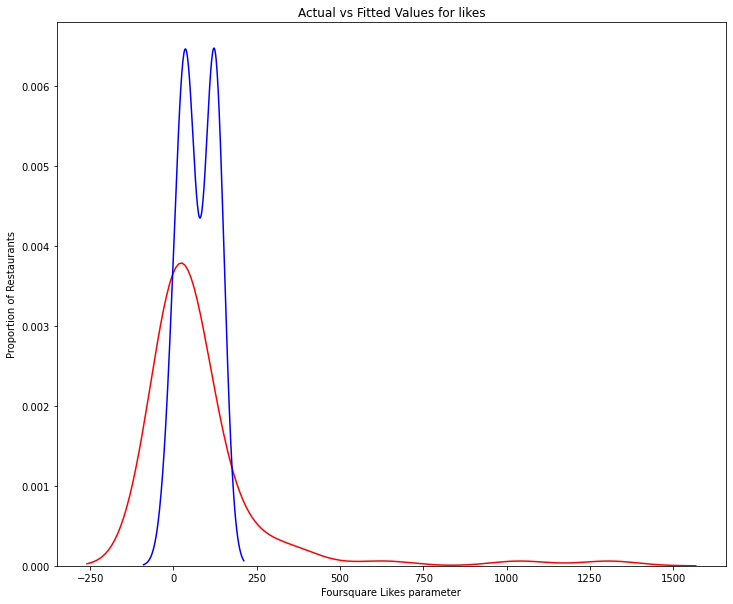

In [23]:
# import the visualization package: seaborn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

width = 12
height = 10

plt.figure(figsize=(width, height))


ax1 = sns.distplot(data['likes'], hist=False, color="r", label="Actual Value")
sns.distplot(y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for likes')
plt.xlabel('Foursquare Likes parameter')
plt.ylabel('Proportion of Restaurants')

plt.show()
plt.close()

As you can see, there's quite a big difference between the actual values and the predicted values where the actual values seem to show a normal distribution.

## Machine Learning Logistic Regression

Something tells me that we can get more valuable data from Logistic regression. Let's take a look at the coefficients.

In [24]:
# Multinomial Ordinal Logistic Regression

x_train = np.asanyarray(train[['american', 'asian', 'casual', 'european', 'latin', 'Monterrey', 'Guadalajara']])
y_train = np.asanyarray(train['ranking'])

x_test = np.asanyarray(test[['american', 'asian', 'casual', 'european', 'latin', 'Monterrey', 'Guadalajara']])
y_test = np.asanyarray(test['ranking'])


mul_ordinal = linear_model.LogisticRegression(multi_class='multinomial',
                                              solver='newton-cg',
                                              fit_intercept=True).fit(x_train,
                                                                      y_train)

mul_ordinal

coef = mul_ordinal.coef_[0]
print (coef)

[-0.2763279  -0.10273631  0.49082673 -0.2483462   0.1365667   0.13676012
 -0.13677711]


In [25]:
# Multinomial Ordinal Logistic Regression Prediction Capabilities

yhat = mul_ordinal.predict(x_test)
yhat

yhat_prob = mul_ordinal.predict_proba(x_test)
yhat_prob


# average = None, average = 'micro', average = 'macro', or average = 'weighted'
jaccard_score(y_test, yhat, average='weighted')

0.5377777777777778

Our Jaccard Index tells us that there's not much similarity between our sets, but again, the sample size might cause some noise to this index.

In [26]:
log_loss(y_test, yhat_prob)

0.6646492522686941

Considering this log_loss value, we are confident to say that our models can't make very useful predictions. It might be due to the size of the sample.

Let's run our logistic regression model once again but with the full dataset.

In [27]:
# Exploration of Coefficient Magnitudes of Full Dataset

x_all = np.asanyarray(reg_dataset[['american', 'asian', 'casual', 'european', 'latin', 'Monterrey', 'Guadalajara']])

y_all = np.asanyarray(reg_dataset['ranking'])



LR = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg', fit_intercept=True).fit(x_all, y_all)

LR

coef = LR.coef_[0]
print(coef)

[-0.23889571 -0.10031343  0.47525144 -0.29638466  0.22194951  0.07354148
 -0.07357553]


There seems to exist some consistency from one set to another based on the coefficients.

In [28]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.73      1.00      0.85        11

    accuracy                           0.73        15
   macro avg       0.24      0.33      0.28        15
weighted avg       0.54      0.73      0.62        15



C:\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Results:

We trained a linear regression model on an aleatory subset of 80% and used the remaining 20% was to test the models. 

Residual sum of squares: 113821.21
Variance score: -0.08

As pointed out previously, the linear regression model did not do a good job modeling our data.

Using the same sample size for training and testing, the multinomial ordinal logistic regression model was performed. Considering that we obtained a jaccard score = 0.53 and a log loss = 0.66, the prediction can't be used for decision making.

A promising result is found in the coefficients that show quite a good consistency:

- Multinomial Ordinal Logistic Regression

    [-0.2763279,  -0.10273631,  0.49082673, -0.2483462,   0.1365667,   0.13676012,  -0.13677711]

- Exploration of Coefficient Magnitudes of Full Dataset

    [-0.23889571, -0.10031343,  0.47525144, -0.29638466,  0.22194951,  0.07354148,  -0.07357553]


### Discussion:

Are this results bad? Not at all, it just gives us a better understanding of the dataset which more than anything is useful for descriptive purposes. However, the coefficients are still a good indicator on how the data behaves and can lead to further research in order to make decisions because this first approach to the restaurant market still delivers useful insights to model and structure a more robust research by determining where to start and what data is missing in order to comprehend better the market opportunities that can be exploited, in this case, to open a new restaurant.

Nevertheless, additional and wider data sources for this cities could improve drastically the performance of these models.

### Conclusion:

As far as we can get with this first analysis, based on 76 restaurants in Guadalajara and Monterrey we can suggest to consider the city of Monterrey as the one with higher chances to open a successful Restaurant of either casual or latin cuisine style. My recommendation is to dig deeper into this insights by utilizing collecting data techniques on Monterrey's costumers in order to come up with an innovative and differenciated gastronomic proposal.